<a href="https://colab.research.google.com/github/dssikdar/ASDRP_Quantum_ML-/blob/Quantum_Conv/TFQ_QCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Todo**
---
> 1. Make all the Conv Layers functions <-- did this
> 2. 2x2 inputs and 4x4 inputs <-- is finished ^
> 3. Adam Optimizer <-- not important right now
> 4. 1.6 in tutorial <-- is finished
> 5. 1.7 in tutorial <-- Saturday

**Installation of Necessary Modules**
1.   Tensorflow==2.4.1
2.   Tensorflow-Quantum
3.   Sympy
4.   Numpy
5.   Google Cirq
6.   Pennylane (Just in Case)



In [1]:
!pip install -q tensorflow==2.4.1 tensorflow-quantum
!pip install cirq sympy numpy pennylane

     |████████████████████████████████| 394.3 MB 13 kB/s 
     |████████████████████████████████| 7.8 MB 12.4 MB/s 
     |████████████████████████████████| 2.9 MB 51.6 MB/s 
     |████████████████████████████████| 3.8 MB 46.7 MB/s 
     |████████████████████████████████| 462 kB 54.1 MB/s 
     |████████████████████████████████| 90 kB 11.3 MB/s 
     |████████████████████████████████| 100 kB 11.6 MB/s 
     |████████████████████████████████| 5.6 MB 15.8 MB/s 
     |████████████████████████████████| 1.3 MB 49.3 MB/s 
     |████████████████████████████████| 90 kB 11.7 MB/s 
     |████████████████████████████████| 380 kB 64.8 MB/s 
     |████████████████████████████████| 1.5 MB 39.9 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 92 kB 1.4 MB/s 
     |████████████████████

**Importing Modules**


1.   Matplotlib.pyplot as plt
2.   SVGCircuit from Cirq.contrib.svg
3.   Tensorflow as tf and Tensorflow_Quantum as tfq
4.   Google Cirq for writing the circuit
5.   Sympy as sp
6.   Numpy as np from Pennylane
7.   Pennylane as qml
8.   Itertools for efficient iteration
9.   Math for doing math
10.  TFDS for loading MNIST
11.  Random for testing Abhik's Function



In [2]:
#%tb #full traceback for errors
%matplotlib inline
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import cirq
from cirq.contrib.svg import SVGCircuit
import sympy as sp
import pennylane
from pennylane import numpy as np
from math import *
from itertools import *
import tensorflow_datasets as tfds #used for loading the MNIST dataset
import numpy #used for convertion of list to Image
import random #used for testing 

**Abhik's Section**

Split the MNIST dataset into the training and testing sets for use.

In [3]:
mnistTrain = list( tfds.load( 'mnist' , split = 'train' , shuffle_files = True ) ) #loads the training subset from the
                                                                    #MNIST dataset from tensorflow datasets as a list
mnistTest = list( tfds.load( 'mnist' , split = 'test' , shuffle_files = True ) ) #loads the testing subset from the 
                                                                    #MNIST dataset from tensorflow datasets as a list

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


**encodeToQuantum() Function**


---
Takes in a list of pixel values of an image and creates a new list of 0's and 1's based on how the pixel compares to the threshold defined (190), thus encoding the pixels into quantum data.  
Arguments: oldPixVals a list of pixel values that comes from a GRAYSCALE (1 byte per pixel) image   
Returns:    newVals                a encoded list of 0s and 1s that represent each pixel from the grayscale image

In [4]:
def encodeImageToQuantum( oldPixVals ) : 
    newVals = []

    #sets the newVals lis to the same size and length of the oldPixVals list, which contains the array of pixel values
    for row in range( len( oldPixVals ) ) :
        newVals.append( [] )
        for col in range( len( oldPixVals[ row ] ) ) :
            newVals[ -1 ].append( -1 )
    
    threshold = 190
    
    #runs through each element of the list, accessing the grayscale value, and assign it a value in the new 1-bit list
    # of pixels based on the threshold
    for row in range( len( oldPixVals ) ) :
        for col in range( len( oldPixVals[ row ] ) ) :
            currPixVal = oldPixVals[ row ][ col ]
            if int(currPixVal[ 0 ]) >= threshold :
                newVals[ row ][ col ] = 1
            else :
                newVals[ row ][ col ] = 0
    
    return newVals #returns new list of values

Each image is converted into a 2d array of pixels, and then the encodeImageToQuantum() method is called for each of the images in both the training and testing subsets.

In [5]:
encodedMnistTrain = []


for currImage in range( len( mnistTrain ) ) : #runs through the mnistTrain list to access the index of each image
    oldImage = mnistTrain[ currImage ][ 'image' ] #accesses the image from the mnistTrain list
    oldImage = numpy.array( oldImage , dtype = numpy.uint8 ) #converts image into usable numpy array object
    encodedMnistTrain.append( encodeImageToQuantum( oldImage ) ) #encodes image into 0s and 1s and appends result
                                                                    #to the end of the 'encodedMnistTrain' list

encodedMnistTest = []

#runs through the mnistTest list and converts each image to an encoded version
for currImage in range( len( mnistTest ) ) : 
    oldImage = mnistTest[ currImage ][ 'image' ]
    oldImage = numpy.array( oldImage , dtype = numpy.uint8 )
    encodedMnistTest.append( encodeImageToQuantum( oldImage ) )

#Testing Code
---
Takes two random images from the training dataset and one from the testing dataset, and shows each image's original form and encoded form. The original form is converted from grayscale, or (x), to RGB values, or (x, x, x). The encoded form is changed into RGB values to be printed, but only two values show up: (255, 255, 255), which is white, or (0, 0, 0), which is black.

###***Example of Output***:

Index #3703 from Training

**Original:**

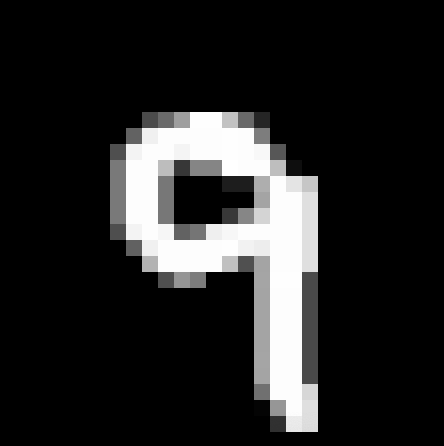

**Encoded:**

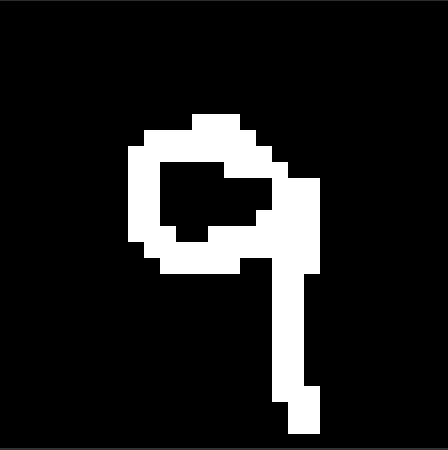

In [6]:
testIndexList = []
testOrigList = []
testEncodeList = []

for i in range(3):
    fromWhichSet = ''
    if i < 2: #uses training set for first two images
        randNum = random.randint( 0 , len( mnistTrain ) ) #generates a random integer from 0 to 60,000 (length of train 
                                                                  #subset)
        randOldImage = mnistTrain[ randNum ][ 'image' ] #takes a random image from the train subset to use for testing
        randNewImage = encodedMnistTrain[ randNum ] #takes the corresponding image from the encoded train subset to use 
                                                        #for testing
        fromWhichSet = ' from Training'
    else: #uses test set for last image
        randNum = random.randint( 0 , len( mnistTest ) ) #generates a random integer from 0 to 60,000 (length of train 
                                                                  #subset)
        randOldImage = mnistTest[ randNum ][ 'image' ] #takes a random image from the train subset to use for testing
        randNewImage = encodedMnistTest[ randNum ] #takes the corresponding image from the encoded train subset to use 
                                                        #for testing
        fromWhichSet = ' from Testing'

    randOldImage = numpy.array( randOldImage , dtype = numpy.uint8 ) #converts image to usable numpy array object
    randNewImage = numpy.array( randNewImage , dtype = numpy.uint8 ) #converts image to usable numpy array object

    newValPixVal = []
    pPixel = []

    #generating original image to print by creating a new array of RGB values, by repeating each value three times 
    # ([value, value, value]) to create an RGB pixel of some shade of gray
    for row in range( len( randOldImage ) ) : #runs through the rows of the image list
        pPixel.append( [] ) #creates a new row when done with the previous row
        for col in range( len( randOldImage[ row ] ) ) : #runs through the columns of the image list
            pPixel[ -1 ].append( [ int( randOldImage[ row ][ col ] ) ,
                                  int( randOldImage[ row ][ col ] ) , 
                                  int( randOldImage[ row ][ col ] ) ] )#appends the new RGB value to the end of newest 
                                                                          #row


    #generating new image to print by multiplying each value by 255, to generate the RGB values of [255, 255, 255]
    # or [0, 0, 0] from the values created by 'encodeImageToQuantum()'
    for row in range( len( randNewImage ) ) :
        newValPixVal.append( [] ) 
        for col in range( len( randNewImage[ row ] ) ) :
            newValPixVal[ -1 ].append( [ randNewImage[ row ][ col ] * 255 , 
                                        randNewImage[ row ][ col ] * 255 , 
                                        randNewImage[ row ][ col ] * 255 ] )

    testIndexList.append('Image #' + str(i+1) + ': ' + str(randNum) + fromWhichSet)

    #converts the pPixel (old Image) array to an Image and displays it as output
    pPixel = numpy.array( pPixel , dtype = numpy.uint8 ) #converts the list into a usable numpy array object
    testOrigList.append(pPixel)
    
    #converts the newValPixVal (new Image) array to an Image and displays it as output
    newValPixVal = numpy.array( newValPixVal , dtype = numpy.uint8 )
    testEncodeList.append(newValPixVal)

###Print out each of the images from the test code.

Image #1: 55066 from Training
Original: 


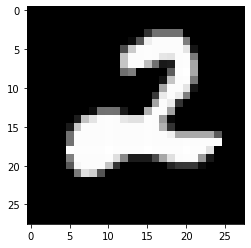

In [7]:
#Image 1
print(testIndexList[0])
print('Original: ')
plt.imshow(testOrigList[0]) #uses the numpy array object print out 

Encoded: 


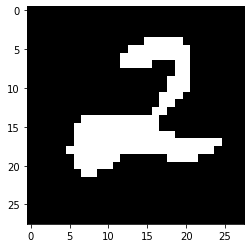

In [8]:
print('Encoded: ')
plt.imshow(testEncodeList[0])

Image #2: 33279 from Training
Original:


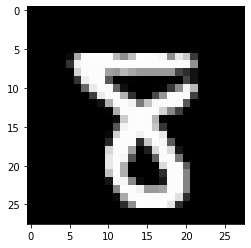

In [9]:
#Image 2
print(testIndexList[1])
print('Original:')
plt.imshow(testOrigList[1])

Encoded: 


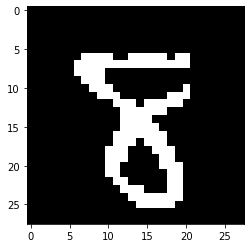

In [10]:
print('Encoded: ')
plt.imshow(testEncodeList[1])

Image #3: 7000 from Testing
Original:


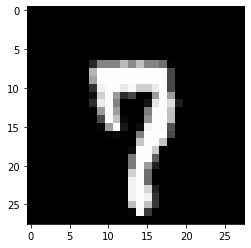

In [11]:
#Image 3
print(testIndexList[2])
print('Original:')
plt.imshow(testOrigList[2])

Encoded: 


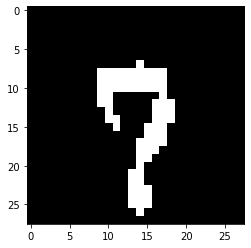

In [12]:
print('Encoded: ')
plt.imshow(testEncodeList[2])

#Convolutional Layers and Pooling

**Function which Creates the Circuit and Qubits**

In [13]:
numOfQubits = 4

In [14]:
def createCircuit(num_qubits):
    qubits = cirq.GridQubit.rect(1, num_qubits)
    circuit = cirq.Circuit()
    return qubits, circuit

In [15]:
qubits, vqc = createCircuit(numOfQubits)

*If you mess up run the "I messed up function"*


**Cluster State PQC**
1. Hadamard all Qubit
2. CNOT each pair of qubits (0,1), (1,2) (2,3), (3,0)

In [16]:
def Cluster_State_PQC(bits):
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

**Rotation Angle Initialization before perfoming Convolution and Pooling and Gate Functions**

In [17]:
def InitRot(numOfAngles=74, angle = np.pi/2):
    return np.array([angle for i in range(numOfAngles)])

In [18]:
default = InitRot()
print(default)

[1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633 1.57079633
 1.57079633 1.57079633]


*Rotation angles subject to changes at any time*

In [19]:
def U3_Gate(bit, params):
    return cirq.Circuit(
        cirq.X(bit)**params[0],
        cirq.Y(bit)**params[1],
        cirq.Z(bit)**params[2])

In [20]:
def CU_Gate(other_bit, bit, params):
    return cirq.Circuit(
        cirq.X(bit).controlled_by(other_bit)**params[0],
        cirq.Y(bit).controlled_by(other_bit)**params[1],
        cirq.Z(bit).controlled_by(other_bit)**params[2])

**Quantum Convolution Layer 1**.  
*Consists of RY gates with fixed angle of rotation (non-trainable) and CNOT pattern as in the PQC* 

In [21]:
def QConvLayer1(qubits): 
    circuit = cirq.Circuit()
    for first in qubits:
        circuit.append(cirq.Ry(rads=np.pi)(first))
    for first, second in zip(qubits[0::1], qubits[1::1] + [qubits[0]]):
        circuit.append(cirq.CNOT(first, second))
    return circuit

**Quantum Convolution Layer 2**  
*Consists of U3 gates applied to each qubit and CU gates applied in the CNOT pattern*

In [22]:
def QConvLayer2(qubits, params):
    circuit = cirq.Circuit()
    index = 0
    for qubit in qubits:
        circuit += U3_Gate(qubit, params[index : index+3])
        index += 3
    for first, second in zip(qubits[0::1], qubits[1::1] + [qubits[0]]):
        circuit += CU_Gate(first, second, params[index : index+3])
        index += 3
    return circuit

**Quantum Convolution Layer 3**

In [23]:
def QConvLayer3(qubits, params):
    circuit = cirq.Circuit()
    index=0
    for qubit in qubits:
        circuit += U3_Gate(qubit, params[index : index+3])
        index += 3
    circuit += cirq.CNOT(control=qubits[0], target=qubits[1])
    circuit += (cirq.CNOT(control=qubits[3], target=qubits[2]))
    circuit += U3_Gate(qubits[0], [np.pi, np.pi, np.pi])
    circuit += U3_Gate(qubits[3], [np.pi/2, np.pi/2, np.pi/2])
    circuit += cirq.CNOT(control=qubits[0], target=qubits[1])
    circuit += cirq.CNOT(control=qubits[3], target=qubits[2])
    return circuit

**Quantum Convolution Layer 4**

In [24]:
def QConvLayer4(qubits, params):
    circuit = cirq.Circuit()
    index = 0
    circuit += U3_Gate(qubits[0], params[0:3])
    for first, second in zip(qubits[0::1], qubits[1::1] + [qubits[0]]):
        circuit += cirq.CNOT(control=first, target=second)
        circuit += CU_Gate(first, second, params[index:index+3])
        index += 3
    return circuit

**Quantum Convolution Layer 5**

In [25]:
def QConvLayer5(qubits, params):
    circuit = cirq.Circuit()
    circuit += U3_Gate(qubits[0], params[0:3])
    circuit += cirq.CNOT(control=qubits[0], target=qubits[1])
    circuit += cirq.CNOT(control=qubits[2], target=qubits[3])
    circuit += U3_Gate(qubits[2], params[3:6])
    circuit += cirq.CNOT(control = qubits[2], target=qubits[1])
    circuit += U3_Gate(qubits[1], params[6:9])
    return circuit

**Quantum Convolution Layer 6**  
*Same as Layer 4 but CU is CNOT*

In [26]:
def QConvLayer6(qubits):
    circuit = cirq.Circuit()
    for i in range(1, len(qubits)):
        circuit += cirq.CNOT(qubits[0], qubits[i])
    circuit += U3_Gate(qubits[3], [np.pi, np.pi/2, np.pi/4])
    return circuit

**Quantum Pooling Layer**  

In [27]:
def QPoolLayer(source, sink, params):
    poolCircuit = cirq.Circuit()
    sinkBasisSelector = U3_Gate(sink, params[0:3])
    sourceBasisSelector = U3_Gate(source, params[3:6])
    poolCircuit.append(sinkBasisSelector)
    poolCircuit.append(sourceBasisSelector)
    poolCircuit.append(cirq.CNOT(control=source, target=sink))
    poolCircuit.append(sinkBasisSelector**-1)
    return poolCircuit

**1.6 Create Model**

In [28]:
def createModelCircuit(qubits, symbols=sp.symbols('param0:74')):
    modelCircuit = cirq.Circuit()
    modelCircuit += QConvLayer1(qubits)
    modelCircuit += QConvLayer2(qubits, symbols[0:24])
    modelCircuit += QConvLayer3(qubits, symbols[24:36])
    modelCircuit += QPoolLayer(qubits[0], qubits[2], symbols[36:42])
    modelCircuit += QConvLayer4(qubits, symbols[42:57])
    modelCircuit += QConvLayer5(qubits, symbols[57:67])
    modelCircuit += QPoolLayer(qubits[1], qubits[3], symbols[67:74])
    modelCircuit += QConvLayer6(qubits)
    return modelCircuit

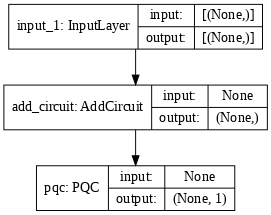

In [29]:
clusterStateBits = cirq.GridQubit.rect(1, 4)
readoutOps = cirq.Z(clusterStateBits[-1])
excitationInput = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
clusterState = tfq.layers.AddCircuit()(excitationInput, prepend=Cluster_State_PQC(clusterStateBits))
QModel = tfq.layers.PQC(createModelCircuit(clusterStateBits), readoutOps)(clusterState)
QCNNModel = tf.keras.Model(inputs=[excitationInput], outputs=[QModel])
tf.keras.utils.plot_model(QCNNModel, show_shapes=True, show_layer_names=True, dpi=70)

**1.7 Training Model**.  
This stuff needs work

In [30]:
@tf.function
#Cusom Accuracy Metric
def customAccuracyMetric(yTrue, yPredicted):
    yTrue = tf.squeeze(yTrue)
    yPredicted = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, yPredicted)
    return tf.keras.backend.mean(tf.keras.backend.equal(yTrue, yPredicted))
#Needs Work

In [31]:
QCNNModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.losses.mse, metrics=[customAccuracyMetric])

**Testing Stuff**

**Generate_Data**.  
Input: A 2D arrays of ones and zeros.  
Does: 2x2 Sliding window for 4 qubits to input.  
Output: Array of all non-overlapping 2x2 windows
   
**Get Training**   
Input: an integer, the number of training examples to extract.  
Does: applies sliding window method to extract 4 qubits worth of information for each example from 0 to how_many
Output: The array of all windows of each training example

   
      
**Get Test**    
same as Get training but the test dataset

In [32]:
#Sliding Window, 2x2 sliding window
def generate_data(arr2d):
    windows = []
    for row in range(0,len(arr2d),2):
        for col in range(0,len(arr2d[row]), 2):
            q0 = arr2d[row][col]
            q1 = arr2d[row][col+1]
            q2 = arr2d[row+1][col]
            q3 = arr2d[row+1][col+1]
            windows.append([[q0,q1],[q2,q3]])
    return windows
    
def get_training(how_many, arr=encodedMnistTrain):
    you_wanted = []
    for i in range(how_many):
        you_wanted.append(generate_data(arr[i]))
    return you_wanted

def get_test(how_many, arr=encodedMnistTrain):
    you_wanted = []
    for i in range(how_many):
        you_wanted.append(generate_data(arr[i]))
    return you_wanted

In [33]:
tr = [encodedMnistTrain[30728], encodedMnistTrain[54477], encodedMnistTrain[3703]]
SL_windows_Tr = []
for sample in tr:
    SL_windows_Tr.append(generate_data(sample))

In [34]:
te = [encodedMnistTest[1717], encodedMnistTest[5231], encodedMnistTest[3828]]
SL_windows_Te = []
for sample in te:
    SL_windows_Te.append(generate_data(sample))

In [35]:
train_data = tf.convert_to_tensor(SL_windows_Tr)
train_labels = np.array([2,0,9])
test_data = tf.convert_to_tensor(SL_windows_Te)
test_labels = np.array([8, 7, 8])